In [23]:
%%bash 
pip3 install dask[complete] toolz cloudpickle
pip3 install matplotlib
pip3 install statsmodels

In [25]:
from __future__ import division
from scipy.stats import linregress
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import dask.dataframe as dd
import pandas as pd
import numpy as np
import math
import time

In [4]:
directory = "CDR_Data_IC/SET1TSV/"
ant_pos_loc = "CDR_Data_IC/"
all_CDR_files = "CDR_Data_IC/SET1TSV/*.TSV"
vor_path = "CDR_Data_IC/Voronoi_Polygons/Proportions/"
points_in_polygon = "CDR_Data_IC/Points_In_Polygon/"

# Retrieve required files for Cote D'Ivoire.
complete_cdr_data = dd.read_csv(all_CDR_files, delim_whitespace=True, header=None, 
                       names=['Date', 'Time', 'Outgoing', 'Terminating', 'Num_Calls', 'Total_Duration'],
                       usecols=['Outgoing', 'Terminating', 'Num_Calls'])

antenna_positions = pd.read_csv(ant_pos_loc + "ANT_POS.TSV", delim_whitespace=True, header=None, 
                                names = ["CT", "Latitude", "Longitude"], index_col="CT")

antenna_info = pd.read_csv(ant_pos_loc + "CT_info.csv", index_col="CT")

voronoi_admin_1 = pd.read_csv(vor_path + "voronoi_admin_1.csv", 
                              usecols=["CT", "O_Area_km2", "ID_1", "P_Area_km2"])

voronoi_admin_2 = pd.read_csv(vor_path + "voronoi_admin_2.csv", 
                              usecols=["CT", "O_Area_km2", "ID_2", "P_Area_km2"])

voronoi_admin_3 = pd.read_csv(vor_path + "voronoi_admin_3.csv", 
                              usecols=["CT", "O_Area_km2", "ID_3", "P_Area_km2"])

pip_admin_1 = pd.read_csv(points_in_polygon + "PIP_Admin_1.csv", usecols=["ID_1", "NUMPOINTS"], index_col="ID_1")
pip_admin_1.index.names = ['Region']
pip_admin_1.sort_index(ascending=True, inplace=True)

pip_admin_2 = pd.read_csv(points_in_polygon + "PIP_Admin_2.csv", usecols=["ID_2", "NUMPOINTS"], index_col="ID_2")
pip_admin_2.index.names = ['Region']
pip_admin_2.sort_index(ascending=True, inplace=True)

pip_admin_3 = pd.read_csv(points_in_polygon + "PIP_Admin_3.csv", usecols=["ID_3", "NUMPOINTS"], index_col="ID_3")
pip_admin_3.index.names = ['Region']
pip_admin_3.sort_index(ascending=True, inplace=True)

In [5]:
def findSameGeoLocatedCTs(CT_pos):
    ids = list(CT_pos.index.unique())
    id_series = CT_pos.index.unique()

    # The CTs which have the same geo-location.
    result = CT_pos[CT_pos.duplicated(["Latitude","Longitude"], keep=False)].sort_values("Latitude")
    return result, ids

same_geo, ids = findSameGeoLocatedCTs(antenna_positions)
print(same_geo)

      Latitude  Longitude
CT                       
331  -6.450498   6.886308
645  -6.450498   6.886308
822  -5.056944   7.725550
493  -5.056944   7.725550
232  -4.204861   6.658500
233  -4.204861   6.658500
998  -4.013608   5.321946
741  -4.013608   5.321946
743  -4.012956   5.322000
737  -4.012956   5.322000
735  -4.012956   5.322000
732  -4.005167   5.327250
1234 -4.005167   5.327250
275  -3.988471   5.341687
1235 -3.988471   5.341687
899  -3.985378   5.297343
900  -3.985378   5.297343
740  -3.103167   5.721778
400  -3.103167   5.721778


In [6]:
def findMissingCTs(CDR_Data):
    present_ids = np.unique(CDR_Data[["Outgoing", "Terminating"]].values)
    result = set(ids) - set(present_ids)
    return result

start = time.time()
missing_data = findMissingCTs(complete_cdr_data)
elapsed = time.time() - start
print(missing_data)
print(elapsed / 60)


{1221, 934, 777, 1130, 301, 1231, 976, 1201, 1232, 691, 340, 1236, 1046, 1238, 1215}
1.8109471519788107


In [7]:
def computeUndirectedWeights(dataframe):
    a = dataframe.copy()
    b = dataframe.copy()

    c = pd.merge(a, b, left_on=['Terminating','Outgoing'], right_on=['Outgoing', 'Terminating'], how='left')
    c = c.fillna(0)
    c['Weight'] = 0

    # If outgoing != incoming then weight = call_a + call_b, else use call_a only.
    c['Weight'] = (c['Num_Calls_x'] + c['Num_Calls_y']).where(c['Outgoing_x'] != c['Terminating_x'], c['Num_Calls_x'])
        
    c.drop(['Outgoing_y', 'Terminating_y'], axis=1, inplace=True)
    c = c.rename(columns={'Outgoing_x': 'Outgoing', 'Terminating_x': 'Terminating', 'Num_Calls_x': 'Num_Calls'})
    c.index.name = 'Index'
    
    return c
    
def preprocessCDRData(CDR_Data):

    keep_columns = ['Outgoing', 'Terminating', 'Num_Calls']
    CDR_Data = CDR_Data[keep_columns]
    
    # Remove any row that has an unknown CT.
    known_outgoing = CDR_Data['Outgoing'] >= 0
    known_terminating = CDR_Data['Terminating'] >= 0
    CDR_Data = CDR_Data[known_outgoing & known_terminating]

    # Initial Grouping to get all existing CT pairs.
    grouped_1 = CDR_Data.groupby(by=['Outgoing', 'Terminating'])
    
    # Sum up Total Number of Calls per (Outgoing, Terminating) pair. 
    all_pairs = grouped_1.sum().compute()
    all_pairs.reset_index(inplace=True)
    all_pairs.index.names = ['Index']
    print("Total number of calls between CT pairs\n")
    print(all_pairs.head())
    print()
    
    # Compute undirected weight of (Outgoing, Terminating) pair.
    bidirectional = computeUndirectedWeights(all_pairs)
    bidirectional.reset_index(inplace=True)
    print("Bidirectional CT Pairs")
    print(bidirectional.head())
    print()
    
    # Group by Outgoing CT.
    CT_grouping = bidirectional.groupby('Outgoing')
    
    # Total Activity for each CT.     
    total_activity = CT_grouping.sum()
    total_activity.reset_index(inplace=True)
    total_activity.set_index('Outgoing', inplace=True)
    total_activity= total_activity.rename(columns={'Weight': 'Total_Weight'}) 
    keep_columns=['Total_Weight']
    total_activity =  total_activity[keep_columns]
    
    print("CTs with total activity")
    print(total_activity.head())
    print()
    
    return bidirectional, CT_grouping, total_activity
    

start = time.time()
bidirectional_CT, CT_groups, total_CT_activity = preprocessCDRData(complete_cdr_data)
elapsed = time.time() - start
print(elapsed / 60)

Total number of calls between CT pairs

       Outgoing  Terminating  Num_Calls
Index                                  
0             1            1      90981
1             1            4        116
2             1            5        459
3             1            9        677
4             1           10        353

Bidirectional CT Pairs
   Index  Outgoing  Terminating  Num_Calls  Num_Calls_y   Weight
0      0         1            1      90981      90981.0  90981.0
1      1         1            4        116        130.0    246.0
2      2         1            5        459        356.0    815.0
3      3         1            9        677        816.0   1493.0
4      4         1           10        353        434.0    787.0

CTs with total activity
          Total_Weight
Outgoing              
1             707770.0
2             159785.0
3             174330.0
4             238144.0
5            3084195.0

1.6724523107210796


In [8]:
# METRIC 1: Activity.

def computeActivity(voronoi_data, CT_activity, region_name, scale):
    regional_activity = pd.DataFrame(columns=['Region', 'Activity'])
    regional_activity['Region'] = list(voronoi_data[region_name].unique())
    regional_activity.set_index('Region', inplace=True)
    regional_activity['Activity'] = 0
    regional_activity.sort_index(ascending=True, inplace=True)
    
    indices = CT_activity.index
        
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]
        proportion = row['P_Area_km2'] / row['O_Area_km2']

        if(ct in indices):
            prev_value = regional_activity.loc[region, 'Activity']
            ct_weight = CT_activity.loc[ct, 'Total_Weight'] * scale
            regional_activity.loc[region, 'Activity'] = (proportion * ct_weight) + prev_value
    
    return regional_activity

regional_activity_1 = computeActivity(voronoi_admin_1, total_CT_activity, "ID_1", 1)
regional_activity_2 = computeActivity(voronoi_admin_2, total_CT_activity, "ID_2", 1)
regional_activity_3 = computeActivity(voronoi_admin_3, total_CT_activity, "ID_3", 1)

regional_activity_1.to_csv(rel_path + "actvity_admin_1.csv", index=True)
regional_activity_2.to_csv(rel_path + "actvity_admin_2.csv", index=True)
regional_activity_3.to_csv(rel_path + "actvity_admin_3.csv", index=True)

print(regional_activity_1)

            Activity
Region              
1       1.942754e+07
2       3.608632e+06
3       9.950119e+07
4       1.802378e+06
5       2.200618e+07
6       2.800852e+07
7       4.213927e+07
8       4.092599e+07
9       3.419255e+08
10      2.326137e+07
11      1.923266e+07
12      2.930079e+07
13      2.829121e+07
14      1.967925e+07
15      2.162206e+07
16      1.939396e+07
17      3.888837e+07
18      7.976312e+06
19      1.492404e+07


In [9]:
# METRIC 3: Network Advantage.

def extractKMedian(ct_activity, grouping):
    ct_activity['kmedian'] = 0
    ct_activity['k_degree'] = 0
    ct_activity['k_sum'] = 0
    
    for name, group in grouping:
        weights = sorted(list(group['Weight']))
        
        mid = int(len(weights) / 2)
        k_mid = weights[mid]
        ct_activity.loc[name, 'kmedian'] = k_mid
        
        k_deg = sum(1 for _ in weights if _ > k_mid)
        ct_activity.loc[name, 'k_degree'] = k_deg
        
        k_sum = sum(x for x in weights if x > k_mid)
        ct_activity.loc[name, 'k_sum'] = k_sum
        
def computeNormalisedEntropy(ct_activity, grouping, ct_pairs, voronoi_data, region_data, region_name):
    
    # Merge CT total activity with pairs to give CT totals & K Medians for purpose of calculating the fractions.    
    merged = pd.merge(ct_pairs, ct_activity, left_on = 'Outgoing', right_index=True)
    keep_columns = ['Index', 'Outgoing', 'Terminating', 'Weight', 'Total_Weight']
    merged =  merged[keep_columns]
    merged.set_index('Index', inplace=True)
    
    # Calculate fraction * log(fraction) per CT pair.     
    fraction = merged['Weight'] / merged['Total_Weight']
    natural_log_fraction = np.log(fraction)
    merged['Fraction_Product'] = fraction * natural_log_fraction

    print("Merged CT_pairs & Total_Activity")
    print(merged.head())
    print()
    
    # Get total of fraction * log(fraction) for each CT. [CT, Sum_Fraction_Product].   
    sum_fraction_product = merged.groupby('Outgoing').sum()
    keep_columns = ['Fraction_Product']
    sum_fraction_product = sum_fraction_product[keep_columns]
    print(sum_fraction_product.head())
    print()
    
    # Merge ct_activity with fraction_product. Add entropy column = sum_fraction_product / log(k_degree).  
    ct_activity = pd.merge(ct_activity, sum_fraction_product, how='left', left_index=True, right_index=True)
    ct_activity['ct_entropy'] = (-1 * (ct_activity['Fraction_Product']) / np.log(ct_activity['k_degree']))
    print(ct_activity.head())
    print()
    
    indices = ct_activity.index
    
    region_entropy = region_data.copy()
    region_entropy['entropy'] = 0
    
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]
        proportion = row['P_Area_km2'] / row['O_Area_km2']

        if(ct in indices):
            prev_value = region_entropy.loc[region, 'entropy']
            new_value = ct_activity.loc[ct, 'ct_entropy']
            region_entropy.loc[region, 'entropy'] = (proportion * new_value) + prev_value
    
    # Normalise entropy by the number of CTs in the region.
    region_entropy['normalised_entropy'] = region_entropy['entropy'] / region_entropy['NUMPOINTS']
    return region_entropy

def computeMedianDegree(ct_activity, ct_pairs, voronoi_data, region_data, region_name, scale):
    # Use total_activity to compute regional_activity.   
    total_activity = ct_activity.copy()
    keep_columns = ['k_sum']
    total_activity = total_activity[keep_columns]
    total_activity.rename(columns={'k_sum' : 'Total_Weight'}, inplace=True)
    print(total_activity.head())
    
    regional_activity = computeActivity(voronoi_data, total_activity, region_name, scale)
    print(regional_activity.head())
    
    # Merge with region_data to get number of CTs in each region.    
    regional_activity = pd.merge(regional_activity, region_data, left_index=True, right_index=True)
    regional_activity['medDegree'] = regional_activity['Activity'] / regional_activity['NUMPOINTS']
    print(regional_activity)
    keep_columns = ['medDegree']
    regional_activity = regional_activity[keep_columns]
    
    return regional_activity

extractKMedian(total_CT_activity, CT_groups)

# Normalised Entropy
norm_entropy_1 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, 
                                          voronoi_admin_1, pip_admin_1, "ID_1")

norm_entropy_2 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, 
                                          voronoi_admin_2, pip_admin_2, "ID_2")

norm_entropy_3 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, 
                                          voronoi_admin_3, pip_admin_3, "ID_3")

# Median Degree.
medDegree_1 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1", 1)
medDegree_2 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2", 1)
medDegree_3 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3", 1)

Merged CT_pairs & Total_Activity
       Outgoing  Terminating   Weight  Total_Weight  Fraction_Product
Index                                                                
0             1            1  90981.0      707770.0         -0.263708
1             1            4    246.0      707770.0         -0.002768
2             1            5    815.0      707770.0         -0.007792
3             1            9   1493.0      707770.0         -0.012997
4             1           10    787.0      707770.0         -0.007563

          Fraction_Product
Outgoing                  
1                -5.457563
2                -5.431752
3                -4.512561
4                -5.705848
5                -4.404411

          Total_Weight  kmedian  k_degree      k_sum  Fraction_Product  \
Outgoing                                                                 
1             707770.0    178.0       596   667762.0         -5.457563   
2             159785.0     30.0       540   153609.0         -5.

            Activity
Region              
1       4.120386e+06
2       5.784873e+05
3       7.457329e+05
4       1.980376e+06
5       1.667298e+06
            Activity  NUMPOINTS     medDegree
Region                                       
1       4.120386e+06          8  5.150482e+05
2       5.784873e+05          1  5.784873e+05
3       7.457329e+05          5  1.491466e+05
4       1.980376e+06          5  3.960753e+05
5       1.667298e+06          4  4.168245e+05
6       7.103631e+06         10  7.103631e+05
7       1.117242e+06          4  2.793105e+05
8       1.502641e+06          5  3.005282e+05
9       1.605379e+05          1  1.605379e+05
10      1.957202e+05          1  1.957202e+05
11      3.429441e+05          0           inf
12      1.800825e+05          1  1.800825e+05
13      2.723847e+05          2  1.361923e+05
14      5.290911e+05          2  2.645456e+05
15      1.852457e+06          2  9.262285e+05
16      6.012841e+06          7  8.589772e+05
17      2.729340e+07     

In [10]:
# METRIC 4: Introversion.

def computeIntroversion(ct_activity, ct_pairs, voronoi_data, region_data, region_name):
    ct_data = ct_pairs.copy()
    
    keep_columns = ['Outgoing', 'Terminating', 'Weight']
    ct_data = ct_data[keep_columns]
    ct_data['Inner_Traffic'] = (ct_data['Weight']).where(ct_data['Outgoing'] == ct_data['Terminating'], 0)
    
    ct_data = ct_data.groupby('Outgoing').sum()
    keep_columns = ['Weight', 'Inner_Traffic']
    ct_data = ct_data[keep_columns]
    
    ct_data['Outer_Traffic'] = ct_data['Weight'] - ct_data['Inner_Traffic']
    ct_data['Introversion'] = ct_data['Inner_Traffic'] / ct_data['Outer_Traffic']
    
    
    indices = ct_activity.index
    
    region_introversion = region_data.copy()
    region_introversion['Introversion'] = 0
    
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]  
        proportion = row['P_Area_km2'] / row['O_Area_km2']


        if(ct in indices):
            prev_value = region_introversion.loc[region, 'Introversion']
            new_value = ct_data.loc[ct, 'Introversion']
            region_introversion.loc[region, 'Introversion'] = (proportion * new_value) + prev_value
    
    region_introversion['avg_introversion'] = region_introversion['Introversion'] / region_introversion['NUMPOINTS']
    return region_introversion
    

start = time.time()

introversion_1 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1")
introversion_2 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2")
introversion_3 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3")

print(introversion_1)

elapsed = time.time() - start
print(elapsed / 60)

        NUMPOINTS  Introversion  avg_introversion
Region                                           
1              42      9.322093          0.221955
2               9      3.096834          0.344093
3             106     28.714022          0.270887
4              12      3.490620          0.290885
5              34      7.842236          0.230654
6              44      9.121054          0.207297
7              68     14.810496          0.217801
8              56      7.951609          0.141993
9             463     39.972966          0.086335
10             37      8.758176          0.236707
11             27      7.228770          0.267732
12             35      9.539967          0.272570
13             50     10.808088          0.216162
14             46     16.061168          0.349156
15             45     11.303679          0.251193
16             39     11.859163          0.304081
17             49      9.241804          0.188608
18             24      7.483868          0.311828


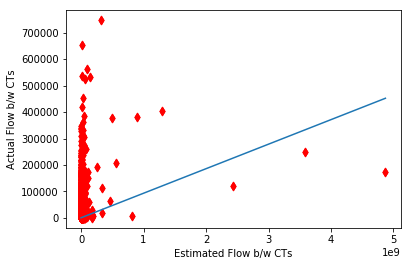

             Weight  estimated_flow        negRes  n_negRes    gResidual
Outgoing                                                                
1          707420.0    5.764881e+06  4.312460e+05       968   445.502022
2          159670.0    4.906130e+06  1.318090e+05      1009   130.633269
3          173333.0    3.477198e+05  7.549028e+04       823    91.725732
4          237941.0    1.372354e+07  2.072055e+05      1075   192.749313
5         3083343.0    3.182639e+06  9.678104e+05       389  2487.944576
6         1212786.0    4.501665e+06  5.404487e+05       605   893.303711
7          168153.0    5.402045e+05  7.245525e+04       875    82.805996
8          401133.0    7.821619e+07  2.558734e+05       992   257.936868
9         2611374.0    2.688266e+05  3.197366e+04       106   301.638255
10        1173488.0    1.355428e+06  2.848024e+05       474   600.848870
11        1003017.0    8.319978e+05  1.656215e+05       455   364.003313
12         739369.0    1.760607e+05  4.337139e+04  

In [40]:
# METRIC 2. GRAVITY RESIDUAL STARTING WITH CT FLOWS.

def calculate_distance(lat_a, long_a, lat_b, long_b):
    earth_radius_km = 6371.0
    lat1 = math.radians(lat_a)
    lon1 = math.radians(long_a)
    lat2 = math.radians(lat_b)
    lon2 = math.radians(long_b)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius_km * c
    return distance

def combineCTInformation(ct_pairs):
    ct_data = ct_pairs.copy()
    ct_data.reset_index(inplace=True)
    keep_columns = ['Outgoing', 'Terminating', 'Weight']
    ct_data = ct_data[keep_columns]
    
    # Join with antenna_info on Outgoing CTs.
    ct_data = pd.merge(ct_data, antenna_info, left_on='Outgoing', right_index=True)
    ct_data.rename(columns={'Latitude':'Out_Lat', 'Longitude' : 'Out_Lng', 'Population' : 'Out_Pop'}, inplace=True)
    
    # Join with antenna_info on Terminating CTs. Note: This distorts usual order but its not an issue.
    ct_data = pd.merge(ct_data, antenna_info, left_on='Terminating', right_index=True)
    ct_data.rename(columns={'Latitude':'Term_Lat', 'Longitude' : 'Term_Lng', 'Population' : 'Term_Pop'}, inplace=True)    
    
    keep_columns = ['Outgoing', 'Terminating', 'Weight', 'Out_Lat', 'Out_Lng', 'Out_Pop', 'Term_Lat', 'Term_Lng', 'Term_Pop']
    ct_data = ct_data[keep_columns]
    ct_data.sort_index(inplace=True)  
    return ct_data

def determine_g(ct_data):
    x = ct_data['estimated_flow']
    y = ct_data['Weight']
    plt.xlabel('Estimated Flow b/w CTs')
    plt.ylabel('Actual Flow b/w CTs')
    
    plt.scatter(ct_data['estimated_flow'], ct_data['Weight'],color='r',marker='d')
    m, b = fit_line(x, y)
    N = 100
    points = np.linspace(x.min(), x.max(), N)
    plt.plot(points, m*points + b)
    plt.show()
    return m

def fit_line(x, y):
    clean_data = pd.concat([x, y], 1).dropna(0) 
    (_, x), (_, y) = clean_data.iteritems()
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept 
    
def computeGravityResidual(CT_pairs):
    ct_data = combineCTInformation(CT_pairs)
    
    #  Computing the estimated flow.   
    population_product = ct_data['Out_Pop'] * ct_data['Term_Pop']
    distance = np.vectorize(calculate_distance)(ct_data['Out_Lat'], ct_data['Out_Lng'], ct_data['Term_Lat'], ct_data['Term_Lng'])
    distance = distance ** 2
    ct_data['estimated_flow'] = population_product / distance
    ct_data = ct_data.replace(np.inf, np.nan)

    g = determine_g(ct_data)
    
    #  Computing the negRes.       
    reduced_ct_data = ct_data.copy()
    reduced_ct_data['negRes'] = (reduced_ct_data['Weight'] - (g * reduced_ct_data['estimated_flow'])).where(reduced_ct_data['Weight'] <
                                                                                                reduced_ct_data['estimated_flow'], 0)
    #  Count the number of negative residuals.
    reduced_ct_data['ones'] = 1
    reduced_ct_data['n_negRes'] = (reduced_ct_data['ones']).where(reduced_ct_data['negRes'] > 0, 0)
    
    #  Computing the gravity residual for each CT.
    ct_data_group = reduced_ct_data.groupby('Outgoing')
    ct_data_group = ct_data_group.sum()
    keep_columns = ['Weight', 'estimated_flow', 'negRes', 'n_negRes']
    ct_data_group = ct_data_group[keep_columns]
    ct_data_group['gResidual'] = ct_data_group['negRes'] / ct_data_group['n_negRes']
    print(ct_data_group)


computeGravityResidual(bidirectional_CT)



In [ ]:
# METRIC 2. GRAVITY RESIDUAL STARTING WITH REGION FLOWS.

def determineCTLocation(voronoi_data, region_name):
    vor_data = voronoi_data.copy()
    vor_data = vor_data.sort_values(['CT','P_Area_km2'],ascending=False).groupby('CT').head(1)
    vor_data.set_index('CT', inplace=True)
    vor_data.sort_index(inplace=True)
    keep_columns = [region_name]
    vor_data = vor_data[keep_columns]
    return vor_data

def combineRegionInformation(ct_to_region, ct_pairs, region_name):
    ct_data = ct_pairs.copy()
    
    ct_data.reset_index(inplace=True)
    keep_columns = ['Outgoing', 'Terminating', 'Weight']
    ct_data = ct_data[keep_columns]
    
    # Add Outgoing CT's region.     
    ct_data = pd.merge(ct_data, ct_to_region, left_on='Outgoing', right_index=True)
    ct_data.rename(columns={region_name : 'Out_region'}, inplace=True)
    
    # Add Terminating CT's region.     
    ct_data = pd.merge(ct_data, ct_to_region, left_on='Terminating', right_index=True)
    ct_data.rename(columns={region_name : 'Term_region'}, inplace=True)
    ct_data.sort_index(inplace=True)
    
    return ct_data
    
def computeGravityResidualRegion(ct_pairs, voronoi_data, region_name):
    ct_to_region = determineCTLocation(voronoi_data, region_name)
    ct_data = combineRegionInformation(ct_to_region, ct_pairs, region_name)
    print(ct_data.head())

computeGravityResidualRegion(bidirectional_CT, voronoi_admin_1, 'ID_1')
    

In [ ]:
# GET THE REGION EACH VORONOI IS IN USING THE REGION IN WHICH MAJORITY OF ITS VORONOI IS IN.
y = voronoi_admin_1.copy()
z = y.sort_values(['CT','P_Area_km2'],ascending=False).groupby('CT').head(1)
z.set_index('CT', inplace=True)
z.sort_index(inplace=True)
z = z['ID_1']

print(z)

# 1,060,783 and 0 => max weight
# 174,644 and 4,870,885,000 => max estimated_flow (large population, small distance)
# x = ct_data.copy()
# x = x.loc[x['Outgoing'] != x['Terminating']]
# print(x.head())